In [16]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xgboost as xgb
from textblob import TextBlob

In [2]:
df = pd.read_json('Digital_Music_5.json', lines=True)

In [3]:
df.shape

(169781, 12)

In [4]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


count                           169781
mean     2014-11-23 17:10:10.287370240
min                1998-07-08 17:00:00
25%                2013-12-12 16:00:00
50%                2015-01-19 16:00:00
75%                2016-02-09 16:00:00
max                2018-09-25 17:00:00
Name: unixReviewTime, dtype: object


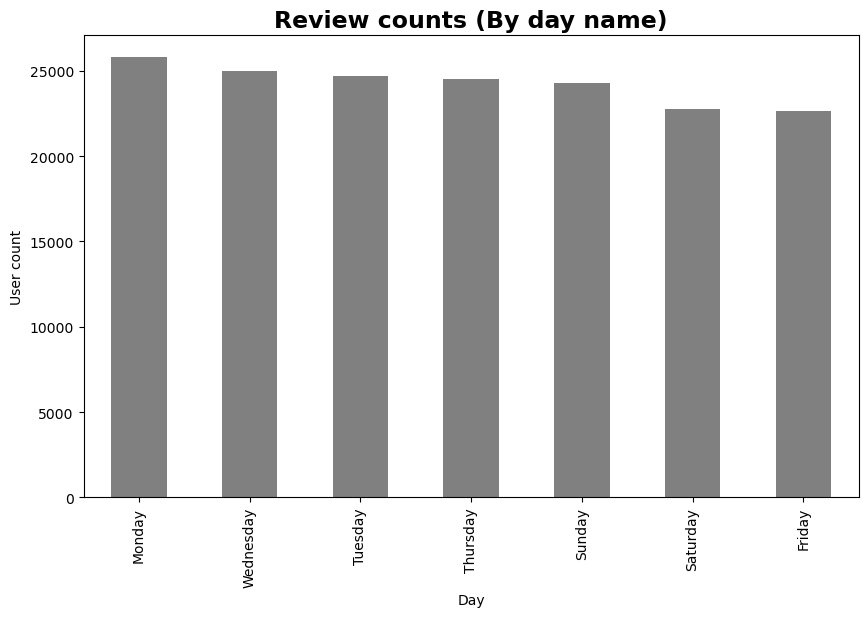

In [5]:
df['unixReviewTime'] = df['unixReviewTime'].map(lambda x: datetime.fromtimestamp(x))
print(df['unixReviewTime'].describe(datetime_is_numeric=True))

df['unixReviewTime'].dt.day_name().value_counts().plot.bar(color='grey',figsize=(10,6))
plt.title("Review counts (By day name)",fontweight='bold',fontsize=17)
plt.xlabel("Day")
plt.ylabel("User count")
plt.show()

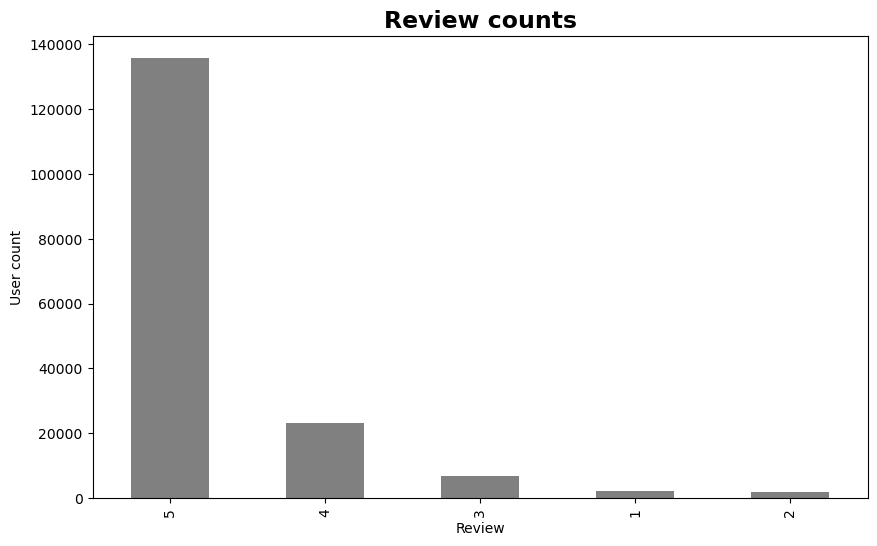

In [6]:
df.overall.value_counts().plot.bar(figsize=(10,6),color='orange')
plt.title("Review counts",fontweight='bold',fontsize=17)
plt.xlabel("Review")
plt.ylabel("User count")
plt.show()

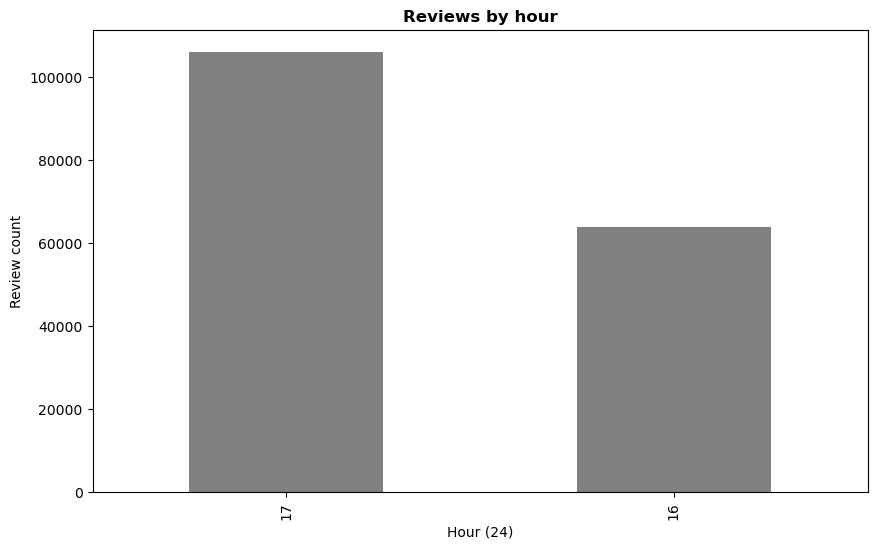

In [7]:
df.unixReviewTime.dt.hour.value_counts().plot.bar(figsize=(10,6),color='grey')
plt.xlabel("Hour (24)")
plt.ylabel("Review count")
plt.title("Reviews by hour",fontweight='bold')
plt.show()

In [8]:
df['style'] = df['style'].astype(str)
df['style'] = df['style'].apply(lambda x: x.split(':')[-1].strip(" }'"))

In [9]:
df['reviewText'].fillna('', inplace=True)

In [10]:
df['polarity_score'] = df['reviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [11]:
def get_feature_by_user(df):
    res = list()
    for i, v in tqdm(df.groupby('reviewerID')):
        res.append(
            (
                i,
                len(v['asin']),
                (v['overall'] == 5).sum(),
                (v['overall'] == 4).sum(),
                (v['overall'] == 3).sum(),
                (v['overall'] == 2).sum(),
                (v['overall'] == 1).sum(),
                (v['unixReviewTime'].dt.dayofweek == 0).sum(),
                (v['unixReviewTime'].dt.dayofweek == 1).sum(),
                (v['unixReviewTime'].dt.dayofweek == 2).sum(),
                (v['unixReviewTime'].dt.dayofweek == 3).sum(),
                (v['unixReviewTime'].dt.dayofweek == 4).sum(),
                (v['unixReviewTime'].dt.dayofweek == 5).sum(),
                (v['unixReviewTime'].dt.dayofweek == 6).sum(),
                (v['unixReviewTime'].dt.hour == 16).sum(), 
                (v['unixReviewTime'].dt.hour == 17).sum(), 
                (v['style'] == 'Amazon Video').sum(), 
                (v['style'] == 'Audio CD').sum(), 
                (v['style'] == 'Audio Cassette').sum(), 
                (v['style'] == 'Blu-ray').sum(), 
                (v['style'] == 'Blu-ray Audio').sum(), 
                (v['style'] == 'DVD').sum(), 
                (v['style'] == 'DVD Audio').sum(), 
                (v['style'] == 'MP3 Music').sum(), 
                (v['style'] == 'Vinyl').sum(), 
                (v['style'] == 'Vinyl Bound').sum(),
                v['polarity_score'].mean()
            )
        )
    
    res = pd.DataFrame(
        res,
        columns=[
            'reviewerID', 'num_product_reviewed', '5_star_ratings_gave', '4_star_ratings_gave',
            '3_star_ratings_gave', '2_star_ratings_gave', '1_star_ratings_gave',
            'monday_review_count_user', 'tuesday_review_count_user', 'wednesday_review_count_user', 'thursday_review_count_user',
            'friday_review_count_user', 'saturday_review_count_user', 'sunday_review_count_user','16_reviews_by_user', 
            '17_reviews_by_user', 'Amazon Video', 'Audio CD', 'Audio Cassette', 'Blu-ray', 'Blu-ray Audio', 'DVD',
            'DVD Audio', 'MP3 Music', 'Vinyl', 'Vinyl Bound', 'user_polarity'
        ])
    return res
   
def get_feature_by_product(df):
    res = list()
    for i, v in tqdm(df.groupby('asin')):
        res.append(
            (
                i,
                len(v['reviewerID']),
                (v['overall'] == 5).sum(),
                (v['overall'] == 4).sum(),
                (v['overall'] == 3).sum(),
                (v['overall'] == 2).sum(),
                (v['overall'] == 1).sum(),
                (v['unixReviewTime'].dt.dayofweek == 0).sum(),
                (v['unixReviewTime'].dt.dayofweek == 1).sum(),
                (v['unixReviewTime'].dt.dayofweek == 2).sum(),
                (v['unixReviewTime'].dt.dayofweek == 3).sum(),
                (v['unixReviewTime'].dt.dayofweek == 4).sum(),
                (v['unixReviewTime'].dt.dayofweek == 5).sum(),
                (v['unixReviewTime'].dt.dayofweek == 6).sum(),
                (v['unixReviewTime'].dt.hour == 16).sum(),
                (v['unixReviewTime'].dt.hour == 17).sum(),
                v['polarity_score'].mean()
            )
        )
    
    res = pd.DataFrame(
        res,
        columns=[
            'asin', 'reviewerID', '1_star_ratings_recieved', '2_star_ratings_recieved',
            '3_star_ratings_recieved', '4_star_ratings_recieved', '5_star_ratings_recieved',
            'monday_review_count_item', 'tuesday_review_count_item', 'wednesday_review_count_item', 'thursday_review_count_item',
            'friday_review_count_item', 'saturday_review_count_item', 'sunday_review_count_item','16_reviews_by_movie', 
            '17_reviews_by_movie', 'item_polarity'
        ])
    return res

In [12]:
# X_train_total = df[df['unixReviewTime'] != df.groupby('reviewerID')['unixReviewTime'].transform('max')]

In [17]:
X = df
y = df[['reviewerID', 'asin', 'overall']]
X_train_total, X_test_total, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train_total.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,polarity_score
129338,3,NaN,True,"07 1, 2014",A20UMJVETOT2II,B0011Z94XM,MP3 Music,itsjustgood,Reminds me of something in the 80s. I like ro...,IT'S OK,2014-06-30 17:00:00,NaN,0.319048
107768,4,10.0,True,"06 2, 2017",A2LX45YMXRLE1E,B00QXY17RC,Vinyl,Edward B. Parsons,Let me start off by saying this is not what I ...,I'm not amused to death....but,2017-06-01 17:00:00,NaN,0.115129
86530,5,NaN,True,"06 25, 2015",A228P1SMLQ4TRB,B00BU2VHOA,MP3 Music,D. Beirne,Greatness.,Five Stars,2015-06-24 17:00:00,NaN,0.000000
82902,5,NaN,True,"07 2, 2016",A184PC2REGOQQX,B009ZAXVGQ,nan,Flowerlillies,Love it.,Love it.,2016-07-01 17:00:00,NaN,0.500000
119827,5,NaN,True,"07 24, 2016",A374HR8027H9KS,B01FV9GS3M,Audio CD,vincevangopher,Dave Davidson has become the most reliable art...,Revocation continue to lead the pack!,2016-07-23 17:00:00,NaN,0.199410


In [19]:
X_train_u = get_feature_by_user(X_train_total)

100%|████████████████████████████████████| 16564/16564 [00:39<00:00, 423.65it/s]


In [20]:
X_train_p = get_feature_by_product(X_train_total)

100%|████████████████████████████████████| 11784/11784 [00:20<00:00, 580.60it/s]


In [21]:
# train_y = X_train_total[['reviewerID', 'asin', 'overall']]
# train_y.head()
train_y = y_train

In [22]:
train_users = X_train_total.reviewerID.values
train_users

array(['A20UMJVETOT2II', 'A2LX45YMXRLE1E', 'A228P1SMLQ4TRB', ...,
       'AA77F985K4AEL', 'A1RPR38LB5B924', 'A748G1WWJBENH'], dtype=object)

In [213]:
# X_test_total = df[df['unixReviewTime'] == df.groupby('reviewerID')['unixReviewTime'].transform('max')]
# X_test_total.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,polarity_score
6,5,NaN,True,"06 6, 2015",A20Z0JD766DPG6,5557706259,Audio CD,M Holley,Another very inspirational collection by a Ver...,Can't say enough. Great Christian music. God...,2015-06-05 17:00:00,NaN,0.476667
7,5,NaN,False,"12 9, 2008",AXQ89O6YRT7AX,5557706259,MP3 Music,PacificHype,"I love the song Slow Fade by Casting Crowns, e...",DEFINITELY DESERVES PERFECT STARS!!!!,2008-12-08 16:00:00,NaN,0.032670
8,5,NaN,False,"10 7, 2008",A1M379MK8MKGUF,5557706259,MP3 Music,Sergio,This is an awesome album from the amazing Chri...,Can't go wrong with Casting Crowns,2008-10-06 17:00:00,NaN,0.229720
14,5,NaN,True,"12 7, 2017",A1XL1WKRIGSTGE,5559166928,Audio CD,bluebird54,Elvis is still the best!,Five Stars,2017-12-06 16:00:00,NaN,1.000000
16,5,NaN,True,"05 15, 2016",A2OOQPH4D33DLM,5559166928,Audio CD,Pathfinder,Outstanding!!,Outstanding!!,2016-05-14 17:00:00,NaN,0.781250


In [23]:
X_test_u = get_feature_by_user(X_test_total)

100%|████████████████████████████████████| 13286/13286 [00:33<00:00, 395.52it/s]


In [24]:
X_test_p = get_feature_by_product(X_test_total)

100%|██████████████████████████████████████| 9886/9886 [00:18<00:00, 539.60it/s]


In [25]:
X_test_p.head()

,asin,reviewerID,1_star_ratings_recieved,2_star_ratings_recieved,3_star_ratings_recieved,4_star_ratings_recieved,5_star_ratings_recieved,monday_review_count_item,tuesday_review_count_item,wednesday_review_count_item,thursday_review_count_item,friday_review_count_item,saturday_review_count_item,sunday_review_count_item,16_reviews_by_movie,17_reviews_by_movie,item_polarity
0,3426958910,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0.890625
1,5557505946,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.800000
2,5557706259,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0.198686
3,5559166928,2,2,0,0,0,0,1,0,0,0,0,1,0,2,0,0.694643
4,7799420340,9,6,3,0,0,0,1,1,2,1,0,2,2,1,8,0.417879


In [26]:
# test_y = X_test_total[['reviewerID', 'asin', 'overall']]
# test_y.head()
test_y = y_test

In [27]:
test_users = X_test_total.reviewerID.values
test_users

array(['A2C2S9BBPWTK9Y', 'AQR5ZB4BIJFLT', 'A3QEOGJXHI6UEG', ...,
       'A2JXX1BAZ19Y4X', 'A2XLYJIQHITC3X', 'A1J5GKR4AX31BP'], dtype=object)

In [28]:
X_train_u.head()

,reviewerID,num_product_reviewed,5_star_ratings_gave,4_star_ratings_gave,3_star_ratings_gave,2_star_ratings_gave,1_star_ratings_gave,monday_review_count_user,tuesday_review_count_user,wednesday_review_count_user,...,Audio CD,Audio Cassette,Blu-ray,Blu-ray Audio,DVD,DVD Audio,MP3 Music,Vinyl,Vinyl Bound,user_polarity
0,A0072041HVZ3465DXUOR,31,29,2,0,0,0,0,0,0,...,0,0,0,0,0,0,31,0,0,0.460403
1,A0081575F2F9XQSSIYA3,9,6,2,1,0,0,0,0,0,...,0,0,0,0,0,0,9,0,0,0.375368
2,A0638585LHS5R1XDIOGY,5,5,0,0,0,0,5,0,0,...,0,0,0,0,0,0,5,0,0,0.590000
3,A1006TXWG76H0N,11,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,1.000000
4,A100UXMXYOQU1X,6,2,1,1,1,1,0,0,6,...,0,0,0,0,0,0,2,0,0,0.303182


In [29]:
X_train_p

,asin,reviewerID,1_star_ratings_recieved,2_star_ratings_recieved,3_star_ratings_recieved,4_star_ratings_recieved,5_star_ratings_recieved,monday_review_count_item,tuesday_review_count_item,wednesday_review_count_item,thursday_review_count_item,friday_review_count_item,saturday_review_count_item,sunday_review_count_item,16_reviews_by_movie,17_reviews_by_movie,item_polarity
0,3426958910,4,3,1,0,0,0,1,1,0,0,2,0,0,3,1,0.418377
1,5557505946,7,7,0,0,0,0,1,0,1,0,1,2,2,5,2,0.374872
2,5557706259,9,7,1,0,1,0,3,1,2,0,2,1,0,2,7,0.275735
3,5559166928,8,7,1,0,0,0,2,1,1,1,1,2,0,3,5,0.682031
4,7799420340,56,46,9,1,0,0,9,10,6,9,7,8,7,15,41,0.337772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11779,B01HHQSCDQ,5,5,0,0,0,0,1,1,1,1,0,0,1,1,4,0.504286
11780,B01HIY8QVU,14,12,2,0,0,0,5,1,2,0,4,2,0,3,11,0.480685
11781,B01HJ91HEC,11,10,1,0,0,0,2,1,2,3,2,0,1,2,9,0.426028
11782,B01HJ91LIY,4,3,1,0,0,0,1,2,0,0,0,0,1,1,3,0.700000


In [30]:
X_test_p

,asin,reviewerID,1_star_ratings_recieved,2_star_ratings_recieved,3_star_ratings_recieved,4_star_ratings_recieved,5_star_ratings_recieved,monday_review_count_item,tuesday_review_count_item,wednesday_review_count_item,thursday_review_count_item,friday_review_count_item,saturday_review_count_item,sunday_review_count_item,16_reviews_by_movie,17_reviews_by_movie,item_polarity
0,3426958910,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0.890625
1,5557505946,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.800000
2,5557706259,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0.198686
3,5559166928,2,2,0,0,0,0,1,0,0,0,0,1,0,2,0,0.694643
4,7799420340,9,6,3,0,0,0,1,1,2,1,0,2,2,1,8,0.417879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9881,B01HHQSCDQ,2,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0.812500
9882,B01HIY8QVU,3,2,1,0,0,0,1,1,0,1,0,0,0,1,2,0.276389
9883,B01HJ91HEC,3,3,0,0,0,0,1,0,1,0,0,0,1,1,2,0.560000
9884,B01HJ91LIY,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0.568182


In [31]:
def get_model_input(X_u, X_m, y, tgt_users):

    merged = pd.merge(X_u, y, on=['reviewerID'], how='inner')
    merged = pd.merge(X_m, merged, on=['asin'], how='outer')
    merged = merged.query('reviewerID_y in @tgt_users')
#     return merged
    # print(merged.columns)

    merged.fillna(0, inplace=True)
    features_cols = list(merged.drop(columns=['reviewerID_y', 'reviewerID_x', 'asin', 'overall']).columns)

    query_list = merged['reviewerID_x'].value_counts()

    merged = merged.set_index(['reviewerID_y', 'asin'])

    query_list = query_list.sort_index()

    merged.sort_index(inplace=True)

    df_x = merged[features_cols]

    df_y = merged['overall']
    
    return df_x, df_y, query_list


In [32]:
# (get_model_input(X_train_u, X_train_p, train_y, train_users)['asin'] == '3426958910').sum()

In [33]:
X_train_p

,asin,reviewerID,1_star_ratings_recieved,2_star_ratings_recieved,3_star_ratings_recieved,4_star_ratings_recieved,5_star_ratings_recieved,monday_review_count_item,tuesday_review_count_item,wednesday_review_count_item,thursday_review_count_item,friday_review_count_item,saturday_review_count_item,sunday_review_count_item,16_reviews_by_movie,17_reviews_by_movie,item_polarity
0,3426958910,4,3,1,0,0,0,1,1,0,0,2,0,0,3,1,0.418377
1,5557505946,7,7,0,0,0,0,1,0,1,0,1,2,2,5,2,0.374872
2,5557706259,9,7,1,0,1,0,3,1,2,0,2,1,0,2,7,0.275735
3,5559166928,8,7,1,0,0,0,2,1,1,1,1,2,0,3,5,0.682031
4,7799420340,56,46,9,1,0,0,9,10,6,9,7,8,7,15,41,0.337772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11779,B01HHQSCDQ,5,5,0,0,0,0,1,1,1,1,0,0,1,1,4,0.504286
11780,B01HIY8QVU,14,12,2,0,0,0,5,1,2,0,4,2,0,3,11,0.480685
11781,B01HJ91HEC,11,10,1,0,0,0,2,1,2,3,2,0,1,2,9,0.426028
11782,B01HJ91LIY,4,3,1,0,0,0,1,2,0,0,0,0,1,1,3,0.700000


In [141]:
(get_model_input(X_train_u, X_train_p, train_y, train_users)['asin'] == '3426958910').sum()

5

In [34]:
X_train, y_train, query_list_train = get_model_input(X_train_u, X_train_p, train_y, train_users)
X_test, y_test, query_list_test = get_model_input(X_test_u, X_test_p, test_y, test_users)

In [176]:
X_train

1_star_ratings_recieved  \
reviewerID_y         asin                                  
A0081575F2F9XQSSIYA3 B00U0AIECQ                       14   
                     B00ZZDJ4J0                        7   
A101PYPZ8ASKCV       B0092MKTWQ                      116   
                     B00B6375Q2                        4   
                     B00FAEQ65Y                       32   
...                                                  ...   
AZYPOLLSDVG4K        B00136LDKQ                       46   
                     B002HP8EKE                       30   
                     B002I53BL0                       16   
                     B00OVKKUW8                       36   
                     B014C4H7PK                        4   

                                 2_star_ratings_recieved  \
reviewerID_y         asin                                  
A0081575F2F9XQSSIYA3 B00U0AIECQ                        6   
                     B00ZZDJ4J0                        0   
A101PYPZ8ASKCV       B0092MKTWQ                       18   
                     B00B6375Q2                        1   
                     B00FAEQ65Y                        3   
...                                                  ...   
AZYPOLLSDVG4K        B00136LDKQ                        6   
                     B002HP8EKE                        9   
                     B002I53BL0                        6   
                     B00OVKKUW8                        5   
                     B014C4H7PK                        1   

                                 3_star_ratings_recieved  \
reviewerID_y         asin                                  
A0081575F2F9XQSSIYA3 B00U0AIECQ                        2   
                     B00ZZDJ4J0                        0   
A101PYPZ8ASKCV       B0092MKTWQ                        3   
                     B00B6375Q2                        0   
                     B00FAEQ65Y                        3   
...                                                  ...   
AZYPOLLSDVG4K        B00136LDKQ                        0   
                     B002HP8EKE                       31   
                     B002I53BL0                        0   
                     B00OVKKUW8                        1   
                     B014C4H7PK                        0   

                                 4_star_ratings_recieved  \
reviewerID_y         asin                                  
A0081575F2F9XQSSIYA3 B00U0AIECQ                        0   
                     B00ZZDJ4J0                        0   
A101PYPZ8ASKCV       B0092MKTWQ                        1   
                     B00B6375Q2                        0   
                     B00FAEQ65Y                        0   
...                                                  ...   
AZYPOLLSDVG4K        B00136LDKQ                        0   
                     B002HP8EKE                       12   
                     B002I53BL0                        0   
                     B00OVKKUW8                        0   
                     B014C4H7PK                        0   

                                 5_star_ratings_recieved  \
reviewerID_y         asin                                  
A0081575F2F9XQSSIYA3 B00U0AIECQ                        1   
                     B00ZZDJ4J0                        0   
A101PYPZ8ASKCV       B0092MKTWQ                        2   
                     B00B6375Q2                        0   
                     B00FAEQ65Y                        0   
...                                                  ...   
AZYPOLLSDVG4K        B00136LDKQ                        0   
                     B002HP8EKE                       23   
                     B002I53BL0                        2   
                     B00OVKKUW8                        0   
                     B014C4H7PK                        0   

                                 monday_review_count_item  \
reviewerID_y         asin                                   
A00815

In [177]:
# X_train.iloc[0]

In [35]:
pd.DataFrame(y_train)

overall
reviewerID_y         asin               
A0072041HVZ3465DXUOR B000V9AUC8        5
                     B000VZWMZ0        5
                     B000VZWMZ0        5
                     B000W1ZDT0        4
                     B000W1ZDT0        4
...                                  ...
AZYPOLLSDVG4K        B014C4H7PK        5
AZZHILYMITLGM        B000TDB4R6        5
                     B00GLP4AJK        5
                     B00GLP4BL2        5
                     B00GLP4DMO        5

[135824 rows x 1 columns]

In [36]:
query_list_train

1       105
2       470
3      2265
4      5876
5      8745
       ... 
207     207
231     231
236     236
255     255
473     473
Name: reviewerID_x, Length: 140, dtype: int64

In [37]:
model = xgb.XGBRanker(objective='rank:ndcg', n_estimators=100, random_state=0,learning_rate=0.1)
model.fit(
    X_train,
    y_train,
    group=query_list_train,
#     eval_metric='ndcg',
#     eval_set=[(X_test, y_test)],
#     eval_group=[list(query_list_test)],
    verbose =True
)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=None, max_leaves=None,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, random_state=0, ...)

In [65]:
def predict_at_k(data, model, k):
    user_ids = list()
    product_ids = list()
    ranks = list()
    i = 0
    
    for userId, df in data.groupby('reviewerID_y'):
        
        pred = model.predict(df.loc[userId])
        if i <= 10:
            print(userId, pred)
            i += 1
        if i == 11:
            return
        productId = np.array(df.reset_index()['asin'])
        topK_index = np.argsort(pred)[::-1][:k]
        product_ids.extend(list(productId[topK_index]))
        user_ids.extend([userId]*len(topK_index))
        ranks.extend(list(range(1, len(topK_index)+1)))

    results = pd.DataFrame({'reviewerID': user_ids, 'asin': product_ids, 'rank': ranks})
    
    return results

predicted = predict_at_k(X_test, model, 3)

def coverage(preds,train_X_p):
    test_recs = preds['asin'].nunique()
    train_movies = X_train_p['asin'].nunique()
    return test_recs/train_movies

A0072041HVZ3465DXUOR [-3.7160933 -3.7160933 -4.117037  -3.0738564 -4.117037  -3.7160933
 -3.4802992 -3.0738564 -3.146577  -3.9379714 -4.2420697]
A0081575F2F9XQSSIYA3 [1.9775566]
A0638585LHS5R1XDIOGY [1.8359194]
A1006TXWG76H0N [2.7114365 2.1787074 2.4285653]
A100UXMXYOQU1X [-4.2781096 -4.250795  -4.2841716]
A101N4D8PRU6N5 [3.0334733 3.9459536 2.2736027 3.5082638 3.5082638]
A101PYPZ8ASKCV [-4.3582993 -4.356892 ]
A101RMTZ93J1KH [1.2440885]
A101ZIBYVW0GVS [3.1691086 3.1691086 2.7114365]
A102H31T5V0LLN [1.3164884 1.7338144]
A102H3QWRBVJ8E [-3.7774706]


In [68]:
df[df['reviewerID'] == 'A0072041HVZ3465DXUOR']

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,polarity_score
5383,5,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B000V9AUC8,MP3 Music,Peking_Duck,This song is a must for your Love Songs collec...,Five Stars,2014-08-02 17:00:00,NaN,0.500000
7130,5,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B000VZWMZ0,MP3 Music,Peking_Duck,Modern alternative music at its best. This so...,Modern alternative music at its best. This son...,2014-08-02 17:00:00,NaN,0.600000
8886,4,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B000W1ZDT0,MP3 Music,Peking_Duck,Although this song is considered seminal for t...,Although this song is considered seminal for t...,2014-08-02 17:00:00,NaN,0.200000
9709,5,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B000WLOMUQ,MP3 Music,Peking_Duck,This song is a must for your portable electron...,Five Stars,2014-08-02 17:00:00,NaN,0.000000
12906,5,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B0011Z74B6,MP3 Music,Peking_Duck,Modern alternative music at its best. This so...,Modern alternative music at its best. This son...,2014-08-02 17:00:00,NaN,0.600000
30458,5,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B000VZWMZ0,MP3 Music,Peking_Duck,Modern alternative music at its best. This so...,Modern alternative music at its best. This son...,2014-08-02 17:00:00,NaN,0.600000
32214,4,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B000W1ZDT0,MP3 Music,Peking_Duck,Although this song is considered seminal for t...,Although this song is considered seminal for t...,2014-08-02 17:00:00,NaN,0.200000
33037,5,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B000WLOMUQ,MP3 Music,Peking_Duck,This song is a must for your portable electron...,Five Stars,2014-08-02 17:00:00,NaN,0.000000
36234,5,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B0011Z74B6,MP3 Music,Peking_Duck,Modern alternative music at its best. This so...,Modern alternative music at its best. This son...,2014-08-02 17:00:00,NaN,0.600000
53589,5,NaN,True,"08 3, 2014",A0072041HVZ3465DXUOR,B001BIMMZ6,MP3 Music,Peking_Duck,Modern alternative music at its best. This so...,Modern alternative music at its best. This son...,2014-08-02 17:00:00,NaN,0.600000


In [67]:
df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image', 'polarity_score'],
      dtype='object')

In [61]:
predicted

array([-3.7160933, -3.7160933, -4.117037 , -3.0738564, -4.117037 ,
       -3.7160933, -3.4802992, -3.0738564, -3.146577 , -3.9379714,
       -4.2420697], dtype=float32)

In [ ]:
X_train_total = train_test_split()

In [188]:
X_test_total

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
6,5,NaN,True,"06 6, 2015",A20Z0JD766DPG6,5557706259,Audio CD,M Holley,Another very inspirational collection by a Ver...,Can't say enough. Great Christian music. God...,2015-06-05 17:00:00,NaN
7,5,NaN,False,"12 9, 2008",AXQ89O6YRT7AX,5557706259,MP3 Music,PacificHype,"I love the song Slow Fade by Casting Crowns, e...",DEFINITELY DESERVES PERFECT STARS!!!!,2008-12-08 16:00:00,NaN
8,5,NaN,False,"10 7, 2008",A1M379MK8MKGUF,5557706259,MP3 Music,Sergio,This is an awesome album from the amazing Chri...,Can't go wrong with Casting Crowns,2008-10-06 17:00:00,NaN
14,5,NaN,True,"12 7, 2017",A1XL1WKRIGSTGE,5559166928,Audio CD,bluebird54,Elvis is still the best!,Five Stars,2017-12-06 16:00:00,NaN
16,5,NaN,True,"05 15, 2016",A2OOQPH4D33DLM,5559166928,Audio CD,Pathfinder,Outstanding!!,Outstanding!!,2016-05-14 17:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
169773,5,NaN,True,"03 14, 2018",A24V7X30NIMOIY,B01HJ91LIY,MP3 Music,Lori Y,Great song and artist,Five Stars,2018-03-13 17:00:00,NaN
169775,5,NaN,True,"03 29, 2017",A1I6UVJCLT4D23,B01HJ91LIY,MP3 Music,Amazon Customer,love it,Five Stars,2017-03-28 17:00:00,NaN
169776,5,NaN,True,"08 19, 2018",A1SR2T84IXOMAQ,B01HJ91MTW,MP3 Music,Diane B.,Casting Crowns songs are all wonderful!!,Great song!!,2018-08-18 17:00:00,NaN
169777,5,NaN,True,"03 18, 2018",A2SR3DWJR1PYR6,B01HJ91MTW,MP3 Music,jan c.,Just reminds you that you are never alone.,Five Stars,2018-03-17 17:00:00,NaN


In [39]:
predicted

,reviewerID,asin,rank
0,A0072041HVZ3465DXUOR,B00C0XWBN4,1
1,A0072041HVZ3465DXUOR,B001BIMMZ6,2
2,A0072041HVZ3465DXUOR,B00CBXKGO4,3
3,A0072041HVZ3465DXUOR,B009G8GTFM,4
4,A0072041HVZ3465DXUOR,B002HK0JCA,5
...,...,...,...
29818,AZXWUZ9PPSOTL,B00136JH3Q,5
29819,AZYOVGJLQ03ML,B01FRF0TSA,1
29820,AZYOVGJLQ03ML,B01F64YXOS,2
29821,AZYPOLLSDVG4K,B002HP8EKE,1


In [58]:
coverage(predicted, X_train_p)

0.7731670061099797

In [49]:
count = 0
for i in range(len(X_test_total)):
    reviewerID = X_test_total.iloc[i]['reviewerID']
    product = X_test_total.iloc[i]['asin']
    if product in predicted[predicted['reviewerID'] == reviewerID]['asin'].values:
        count += 1

In [50]:
count / len(X_test_total)

0.769914892363872

In [51]:
# LightGBM Ranker
lgb_model = LGBMRanker(n_estimators=100, random_state=0,learning_rate=0.1)
lgb_model.fit(
    X_train,
    y_train,
    group=query_list_train,
#     eval_metric='ndcg',
#     eval_set=[(X_test, y_test)],
#     eval_group=[list(query_list_test)],
    verbose =True
)

/Users/jessica/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRanker(random_state=0)

In [55]:
lgb_predicted = predict_at_k(X_test, lgb_model, 3)

In [56]:
count = 0
for i in range(len(X_test_total)):
    reviewerID = X_test_total.iloc[i]['reviewerID']
    product = X_test_total.iloc[i]['asin']
    if product in lgb_predicted[lgb_predicted['reviewerID'] == reviewerID]['asin'].values:
        count += 1
        

In [57]:
count / len(X_test_total)

0.7706216685808522

In [59]:
coverage(lgb_predicted, X_train_p)

0.7710454854039376

In [230]:
count / len(X_test_total)

0.692844181459566

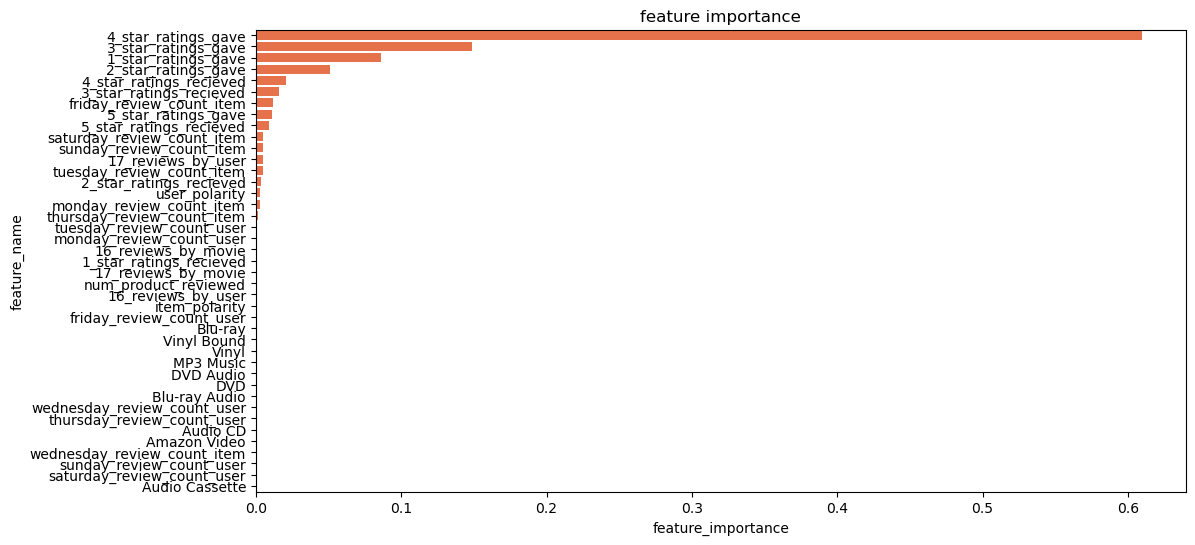

In [232]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()